#### Problem Statement from Kaggle: 

#### _Analyze weather and GIS data to predict whether or not West Nile Virus is present, for a given time, location and species._ 


### Purpose of this notebook is to process the various Kaggle datasets and create a new dataset to be used for EDA and modeling.

In [165]:
import pandas as pd
import numpy as np
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
# Verify geo locator is in place to assist with coordinates
geolocator = Nominatim()
location = geolocator.geocode("175 5th Avenue NYC")
print(location)

Flatiron Building, 175, 5th Avenue, Flatiron Building, Manhattan Community Board 5, New York County, NYC, New York, 10010, United States of America


#### Read in Kaggel csv data files

In [3]:
weather = pd.read_csv('../assets/weather.csv')
print(weather.shape)

(2944, 22)


In [4]:
spray = pd.read_csv('../assets/spray.csv')
print(spray.shape)

(14835, 4)


In [5]:
train = pd.read_csv('../assets/train.csv')
print(train.shape)

(10506, 12)


In [6]:
test = pd.read_csv('../assets/test.csv')
print(test.shape)

(116293, 11)


## Process Data
#### Part I will focus on the initial review of data and joining data from the spray, training and weather datasets into one dataframe

### Training data for mosquito trap testing

In [7]:
train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [8]:
# Convert date from object to datetime type and the extract parts into separate columns
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
train['Day'] = train['Date'].apply(lambda x: x.day)

In [12]:
# Run to verify that conversion took
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Year                      10506 non-null int64
Month                     10506 non-null int64
Day                       10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(5)
memory usage: 1.2+ MB


#### West Nile Virus Presence by Species and Year

In [77]:
df_train1 = pd.DataFrame(train.groupby(['Species']).agg({'NumMosquitos':'sum','WnvPresent': 'sum', 'Date': 'size'})).reset_index()
df_train1.sort_values([ 'Species' ], ascending=False)

,Species,NumMosquitos,WnvPresent,Date
6,CULEX TERRITANS,510,0,222
5,CULEX TARSALIS,7,0,6
4,CULEX SALINARIUS,145,0,86
3,CULEX RESTUANS,23431,49,2740
2,CULEX PIPIENS/RESTUANS,66268,262,4752
1,CULEX PIPIENS,44671,240,2699
0,CULEX ERRATICUS,7,0,1


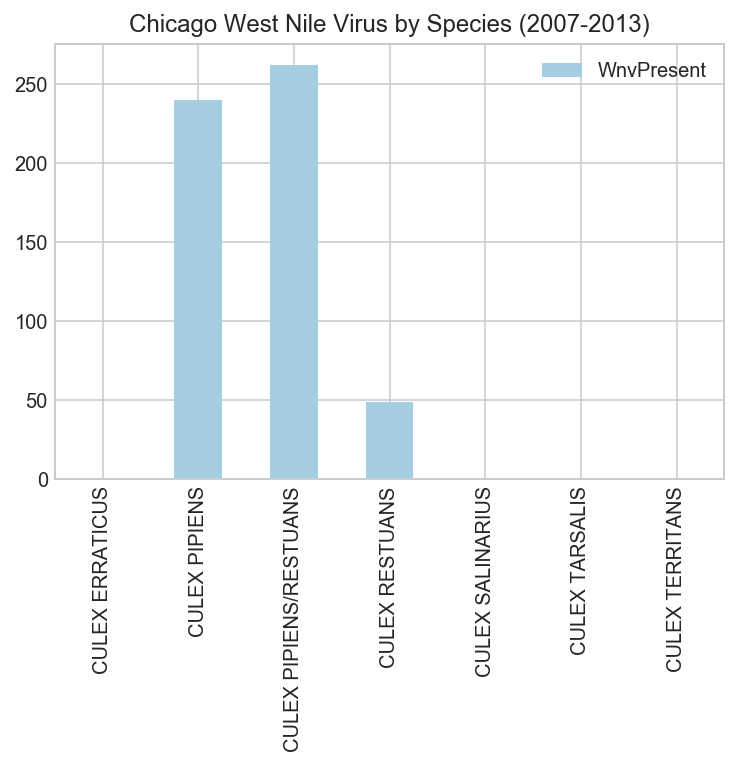

In [78]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

cmap = cm.get_cmap('Paired')

df = df_train1[['Species','WnvPresent']]

ax = df.plot(kind='bar', colormap=cmap)
ax.set_title('Chicago West Nile Virus by Species (2007-2013)')
ax.set_xticks(range(len(df_train1['Species'])))
ax.set_xticklabels(df_train1['Species'], rotation='vertical')

plt.show();

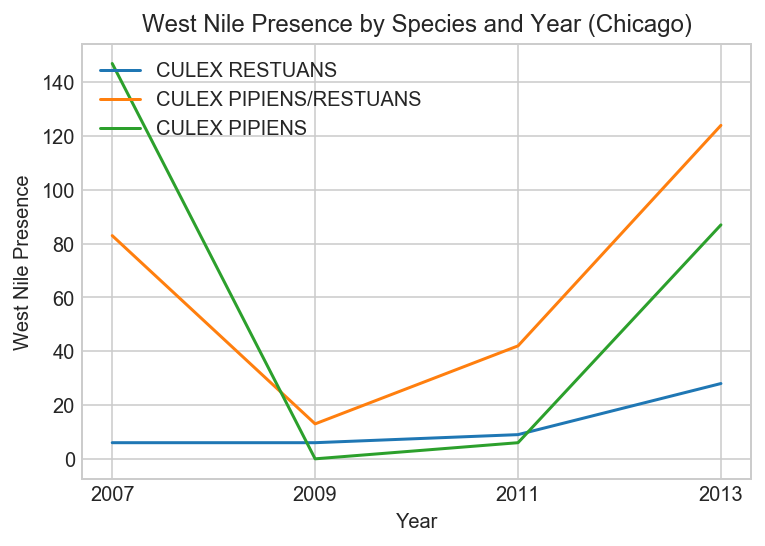

In [87]:
df_train2 = pd.DataFrame(train.groupby(['Year','Species']).agg({'NumMosquitos':'sum','WnvPresent': 'sum', 'Date': 'size'})).reset_index()

df1 = df_train2[['Year','WnvPresent']][df_train2['Species']=='CULEX RESTUANS']
df2 = df_train2[['Year','WnvPresent']][df_train2['Species']=='CULEX PIPIENS/RESTUANS']
df3 = df_train2[['Year','WnvPresent']][df_train2['Species']=='CULEX PIPIENS']

plt.plot(df1['Year'], df1['WnvPresent'])
plt.plot(df2['Year'], df2['WnvPresent'])
plt.plot(df3['Year'], df3['WnvPresent'])

plt.xticks([w for w in df1['Year']])
plt.title('West Nile Presence by Species and Year (Chicago)')
plt.legend(['CULEX RESTUANS', 'CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS'], loc='upper left')
plt.xlabel('Year')
plt.ylabel('West Nile Presence')

plt.show();

#### WNV presence grouped by Year, Month, Species and Location and sorted by presence
As indicated by above plot, highest counts are in 2007 and then 2013.

In [167]:
df2 = pd.DataFrame(train.groupby(['Year','Month','Species','Trap', 'Street']).agg({'NumMosquitos':'sum','WnvPresent': 'sum', 'Date': 'size'})).reset_index()
df2[(df2['Species'] =='CULEX PIPIENS/RESTUANS') |
    (df2['Species'] =='CULEX PIPIENS') | 
    (df2['Species'] =='RESTUANS')].sort_values(['WnvPresent'], ascending=False).head(20)

,Year,Month,Species,Trap,Street,NumMosquitos,WnvPresent,Date
458,2007,8,CULEX PIPIENS,T115,S DOTY AVE,9253,21,190
3226,2013,8,CULEX PIPIENS/RESTUANS,T900,W OHARE AIRPORT,1577,16,54
462,2007,8,CULEX PIPIENS,T138,S STONY ISLAND AVE,6141,13,133
3153,2013,8,CULEX PIPIENS,T900,W OHARE AIRPORT,496,12,25
3445,2013,9,CULEX PIPIENS/RESTUANS,T900,W OHARE AIRPORT,640,9,19
2504,2011,8,CULEX PIPIENS/RESTUANS,T900,W OHARE AIRPORT,359,6,21
802,2007,9,CULEX PIPIENS,T115,S DOTY AVE,3362,6,69
459,2007,8,CULEX PIPIENS,T128,E 105TH ST,1702,6,37
3373,2013,9,CULEX PIPIENS,T900,W OHARE AIRPORT,546,5,23
495,2007,8,CULEX PIPIENS/RESTUANS,T002,N OAK PARK AVE,208,5,7


#### WNV presence by Month and Location.
Highest counts occur mainly in August (regardless of year). Only a few in September.

In [168]:
info = df2[['Month', 'Street', 'WnvPresent']][(df2['Species'] =='CULEX PIPIENS/RESTUANS') | (df2['Species'] =='CULEX PIPIENS') | (df2['Species'] =='RESTUANS')].sort_values(['WnvPresent'], ascending=False)
#info.to_csv('../output/wnv_month_street.csv', index=False)
info.head(20)

,Month,Street,WnvPresent
458,8,S DOTY AVE,21
3226,8,W OHARE AIRPORT,16
462,8,S STONY ISLAND AVE,13
3153,8,W OHARE AIRPORT,12
3445,9,W OHARE AIRPORT,9
2504,8,W OHARE AIRPORT,6
802,9,S DOTY AVE,6
459,8,E 105TH ST,6
3373,9,W OHARE AIRPORT,5
495,8,N OAK PARK AVE,5


In [122]:
train.sort_values(['Year','Block','Trap']).tail(100)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Day
9048,2013-07-25,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,20,0,2013,7,25
9198,2013-08-01,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS/RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,16,0,2013,8,1
9199,2013-08-01,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,2,0,2013,8,1
9200,2013-08-01,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,7,0,2013,8,1
9389,2013-08-08,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS/RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,43,0,2013,8,8
9390,2013-08-08,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,9,0,2013,8,8
9391,2013-08-08,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,1,0,2013,8,8
9565,2013-08-15,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS/RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,33,0,2013,8,15
9566,2013-08-15,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,4,0,2013,8,15
9567,2013-08-15,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX PIPIENS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",41.732984,-87.649642,8,7,0,2013,8,15


### Weather Data

**_It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests._** 

Based on the above comment from Kaggle, we will focus on **Heating** and **Cooling** days along with **Total Precipitation**, **Dew Point** and **WetBulb**

Link to NOAA doc that explains heating and cooling days
http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/cdus/degree_days/ddayexp.shtml

In [9]:
print(weather.shape)
weather.head(2)

(2944, 22)


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6


### Weather Data

### Extract weather data for Station 1

In [10]:
weather_st1 = weather[weather['Station'] == 1]
weather_st1 = weather_st1[['Date', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal']]
weather_st1['Date'] = pd.to_datetime(weather_st1['Date'])
weather_st1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 6 columns):
Date           1472 non-null datetime64[ns]
DewPoint       1472 non-null int64
WetBulb        1472 non-null object
Heat           1472 non-null object
Cool           1472 non-null object
PrecipTotal    1472 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 80.5+ KB


### Create merged train dataframe with daily weather info

In [11]:
train_mrg = train.copy()
train_mrg = train_mrg.merge(weather_st1, how='inner', left_on=['Date'], right_on=['Date'])
train_mrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 20 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Year                      10506 non-null int64
Month                     10506 non-null int64
Day                       10506 non-null int64
DewPoint                  10506 non-null int64
WetBulb                   10506 non-null object
Heat                      10506 non-null object
Cool                     

In [12]:
train_mrg['WetBulb'] = train_mrg['WetBulb'].apply(lambda x: x.replace('M', '0')).astype('int')
train_mrg['Cool'] = train_mrg['Cool'].apply(lambda x: x.replace('M', '0')).astype('int')
train_mrg['Heat'] = train_mrg['Heat'].apply(lambda x: x.replace('M', '0')).astype('int')
train_mrg['PrecipTotal'] = train_mrg['PrecipTotal'].apply(lambda x: x.replace('M', '0'))
train_mrg['PrecipTotal'] = train_mrg.PrecipTotal.str.replace(' ', '').str.replace('T', '0.0').astype('float')
train_mrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 20 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Year                      10506 non-null int64
Month                     10506 non-null int64
Day                       10506 non-null int64
DewPoint                  10506 non-null int64
WetBulb                   10506 non-null int64
Heat                      10506 non-null int64
Cool                      1

In [13]:
train_mrg[['Date','Species','Block','Trap',
       'WnvPresent','NumMosquitos','Heat',
       'Cool','PrecipTotal', 'WetBulb', 'DewPoint']].head()

,Date,Species,Block,Trap,WnvPresent,NumMosquitos,Heat,Cool,PrecipTotal,WetBulb,DewPoint
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,0,1,0,9,0.0,65,58
1,2007-05-29,CULEX RESTUANS,41,T002,0,1,0,9,0.0,65,58
2,2007-05-29,CULEX RESTUANS,62,T007,0,1,0,9,0.0,65,58
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,0,1,0,9,0.0,65,58
4,2007-05-29,CULEX RESTUANS,79,T015,0,4,0,9,0.0,65,58


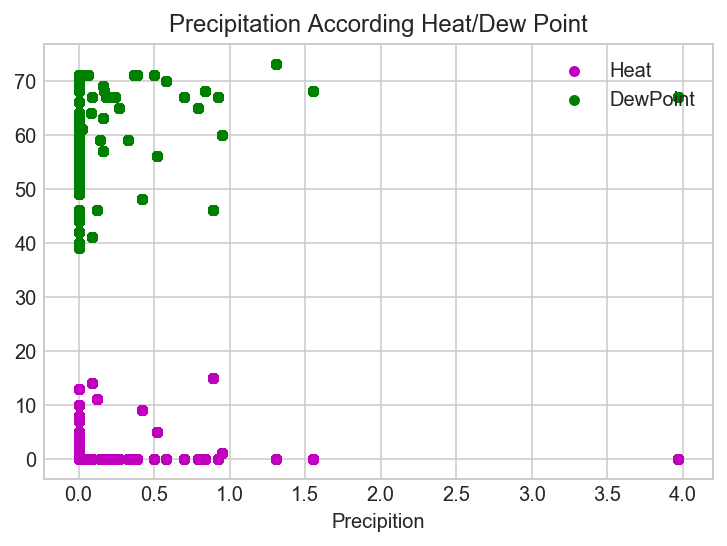

In [74]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

precip = train_mrg['PrecipTotal']
heat = train_mrg['Heat']
dew = train_mrg['DewPoint']

ax1.scatter(precip, heat, s=20, c='m', marker="o", label='Heat')
ax1.scatter(precip, dew, s=20, c='green', marker="o", label='DewPoint')
plt.legend(loc='upper right');
plt.title('Precipitation According Heat/Dew Point')
plt.xlabel('Precipition');

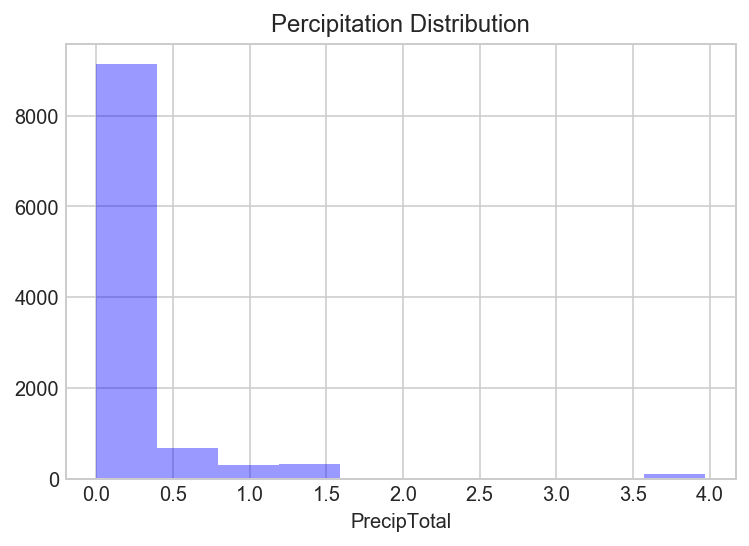

In [164]:
sns.distplot(precip, bins=10, kde=False, color="blue").set_title("Percipitation Distribution");

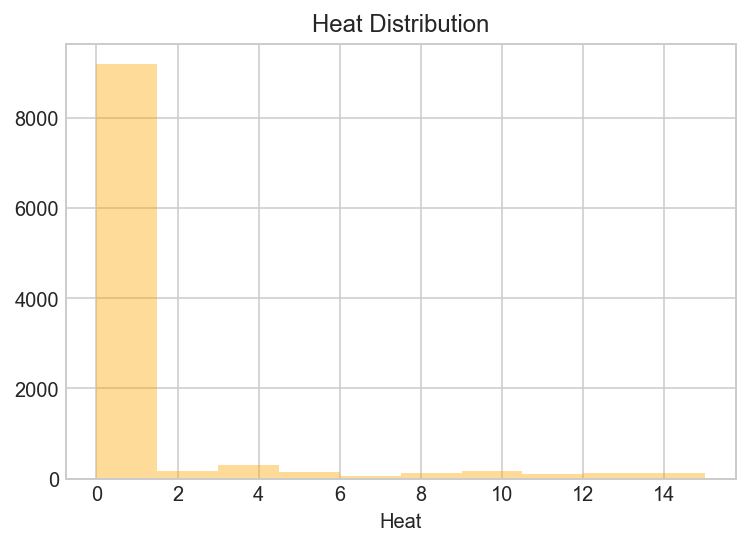

In [170]:
sns.distplot(heat, bins=10, kde=False, color="orange").set_title("Heat Distribution");

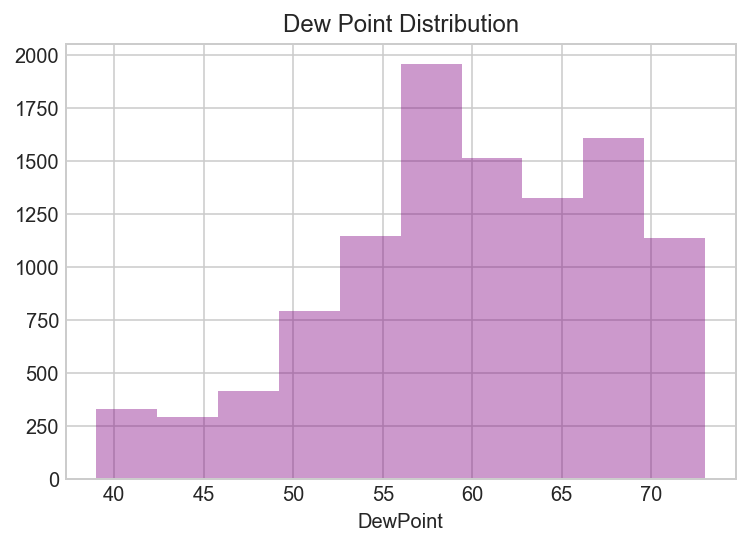

In [169]:
sns.distplot(dew, bins=10, kde=False, color="purple").set_title("Dew Point Distribution");

In [75]:
train_mrg.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Day,DewPoint,WetBulb,Heat,Cool,PrecipTotal
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,2007,5,29,58,65,0,9,0.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,2007,5,29,58,65,0,9,0.0


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('white')

demo = pd.read_csv('./datasets/simple_demographics.csv')

#### Write train data to csv

In [326]:
# !! NOTE write to csv file
train_mrg.to_csv('../output/train_weather_daily.csv', index=False)

### Create Test DataFrame with daily weather info 

#### The test data from Kaggle will have to be prepared like the training dataset

In [14]:
test_mrg = test.copy()
test_mrg['Date'] = pd.to_datetime(test_mrg['Date'])
test_mrg['Year'] = test_mrg['Date'].apply(lambda x: x.year)
test_mrg['Month'] = test_mrg['Date'].apply(lambda x: x.month)
test_mrg['Day'] = test_mrg['Date'].apply(lambda x: x.day)

In [15]:
test_mrg = test_mrg.merge(weather_st1, how='inner', left_on=['Date'], right_on=['Date'])
test_mrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 19 columns):
Id                        116293 non-null int64
Date                      116293 non-null datetime64[ns]
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
Year                      116293 non-null int64
Month                     116293 non-null int64
Day                       116293 non-null int64
DewPoint                  116293 non-null int64
WetBulb                   116293 non-null object
Heat                      116293 non-null object
Cool                      116293 non-null object
Prec

In [16]:
test_mrg['WetBulb'] = test_mrg['WetBulb'].apply(lambda x: x.replace('M', '0')).astype('int')
test_mrg['Cool'] = test_mrg['Cool'].apply(lambda x: x.replace('M', '0')).astype('int')
test_mrg['Heat'] = test_mrg['Heat'].apply(lambda x: x.replace('M', '0')).astype('int')
test_mrg['PrecipTotal'] = test_mrg['PrecipTotal'].apply(lambda x: x.replace('M', '0'))
test_mrg['PrecipTotal'] = test_mrg.PrecipTotal.str.replace(' ', '').str.replace('T', '0.0').astype('float')
test_mrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 19 columns):
Id                        116293 non-null int64
Date                      116293 non-null datetime64[ns]
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
Year                      116293 non-null int64
Month                     116293 non-null int64
Day                       116293 non-null int64
DewPoint                  116293 non-null int64
WetBulb                   116293 non-null int64
Heat                      116293 non-null int64
Cool                      116293 non-null int64
PrecipT

In [17]:
test_mrg[['Date','Species','Block','Trap','Heat','Cool','PrecipTotal','WetBulb','DewPoint']].head()

,Date,Species,Block,Trap,Heat,Cool,PrecipTotal,WetBulb,DewPoint
0,2008-06-11,CULEX PIPIENS/RESTUANS,41,T002,0,9,0.0,64,56
1,2008-06-11,CULEX RESTUANS,41,T002,0,9,0.0,64,56
2,2008-06-11,CULEX PIPIENS,41,T002,0,9,0.0,64,56
3,2008-06-11,CULEX SALINARIUS,41,T002,0,9,0.0,64,56
4,2008-06-11,CULEX TERRITANS,41,T002,0,9,0.0,64,56


#### Write test dataframe to csv

In [338]:
# !! NOTE write to csv file
test_mrg.to_csv('../output/test_weather_daily.csv', index=False)

### Create Train dataframe with monthly weather averages

In [18]:
weather.info() 
# No nulls, but will have to change column types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [19]:
# Drop rows that have an M (missing data)
df_weather = weather[(weather.WetBulb != 'M') & (weather.Cool != 'M') & (weather.Heat != 'M') & (weather.PrecipTotal != 'M')]
print(df_weather.shape)

(2927, 22)


In [20]:
# Drop rows where precip == T
df_weather = df_weather[df_weather.PrecipTotal.str.replace(' ', '') != 'T']
print(df_weather.shape)

(2610, 22)


In [21]:
# Convert to numerics so we can average
df_weather['WetBulb'] = df_weather['WetBulb'].astype('int')
df_weather['DewPoint'] = df_weather['DewPoint'].astype('int')
df_weather['Cool'] = df_weather['Cool'].astype('int')
df_weather['Heat'] = df_weather['Heat'].astype('int')
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype('float')

** Get daily average based on Station 1 and Station 2 ** - doing this since rows were removed for missing or trace values.

In [22]:
# Group by date so each group includes data from Station and Station 2 and then get averages
# Note to remember that some obervations were dropped due Missing and Trace
df_weather2 = pd.DataFrame(df_weather.groupby(['Date']).agg({'Heat': 'mean', 'Cool': 'mean', 
                                                             'PrecipTotal': 'mean', 
                                                             'DewPoint': 'mean', 'WetBulb': 'mean'})).reset_index()

In [23]:
# convert date from object to datetime and extract components into separate columns
df_weather2['Date'] = pd.to_datetime(df_weather2['Date'])
df_weather2['Year'] = df_weather2['Date'].apply(lambda x: x.year)
df_weather2['Month'] = df_weather2['Date'].apply(lambda x: x.month)
df_weather2['Day'] = df_weather2['Date'].apply(lambda x: x.day)

In [61]:
df_weather2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 9 columns):
Date           1405 non-null datetime64[ns]
Heat           1405 non-null float64
Cool           1405 non-null float64
PrecipTotal    1405 non-null float64
DewPoint       1405 non-null float64
WetBulb        1405 non-null float64
Year           1405 non-null int64
Month          1405 non-null int64
Day            1405 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 98.9 KB


#### Get monthly averages

In [24]:
df_weather3 = pd.DataFrame(df_weather2.groupby(['Year', 'Month']).agg({'Heat': 'mean', 
                                                                       'Cool': 'mean', 'PrecipTotal': 'mean',
                                                                       'DewPoint': 'mean', 'WetBulb': 'mean'})).reset_index()
print(df_weather3.shape)

# convert back to integers
df_weather3['Heat'] = round(df_weather3['Heat']).astype('int')
df_weather3['Cool'] = round(df_weather3['Cool']).astype('int')
df_weather3['WetBulb'] = round(df_weather3['WetBulb']).astype('int')
df_weather3['DewPoint'] = round(df_weather3['DewPoint']).astype('int')
#df_weather3.head()

df_weather3.columns = ['Year', 'Month', 'HeatMonthAvg', 
                       'CoolMonthAvg', 'PrecipTtlMonthAvg', 'WetBulbMonthAvg','DewPointMonthAvg' ]

(48, 7)


In [25]:
df_weather3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
Year                 48 non-null int64
Month                48 non-null int64
HeatMonthAvg         48 non-null int64
CoolMonthAvg         48 non-null int64
PrecipTtlMonthAvg    48 non-null float64
WetBulbMonthAvg      48 non-null int64
DewPointMonthAvg     48 non-null int64
dtypes: float64(1), int64(6)
memory usage: 2.7 KB


#### Merge training data with monthly weather averages

In [26]:
df_train_mrg2 = train.copy()
dft_avg = df_train_mrg2.merge(df_weather3, how='inner', left_on=['Year', 'Month'], right_on=['Year', 'Month'])

In [27]:
dft_avg[['Date','Species','Block','Trap',
       'WnvPresent','NumMosquitos','HeatMonthAvg',
       'CoolMonthAvg','PrecipTtlMonthAvg', 'WetBulbMonthAvg', 'DewPointMonthAvg']].tail(10)

,Date,Species,Block,Trap,WnvPresent,NumMosquitos,HeatMonthAvg,CoolMonthAvg,PrecipTtlMonthAvg,WetBulbMonthAvg,DewPointMonthAvg
10496,2013-09-26,CULEX PIPIENS/RESTUANS,17,T224,0,3,2,5,0.078276,54,60
10497,2013-09-26,CULEX PIPIENS/RESTUANS,90,T226,0,8,2,5,0.078276,54,60
10498,2013-09-26,CULEX PIPIENS/RESTUANS,13,T230,0,13,2,5,0.078276,54,60
10499,2013-09-26,CULEX PIPIENS,13,T230,0,5,2,5,0.078276,54,60
10500,2013-09-26,CULEX PIPIENS/RESTUANS,39,T228,0,3,2,5,0.078276,54,60
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,T035,1,6,2,5,0.078276,54,60
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,T231,0,5,2,5,0.078276,54,60
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,T232,0,1,2,5,0.078276,54,60
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,T233,0,5,2,5,0.078276,54,60
10505,2013-09-26,CULEX PIPIENS/RESTUANS,42,T235,0,1,2,5,0.078276,54,60


#### Write data to csv file

In [380]:
# !! NOTE write to csv file
dft_avg.to_csv('../output/train_month_avg_weather.csv', index=False)

### Spray Data
**Data for just 2011 and 2013**

In [28]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [29]:
spray.info()
# Missing Time values, but we can leave them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [30]:
# Convert Date to datetime and break apart
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Year'] = spray['Date'].apply(lambda x: x.year)
spray['Month'] = spray['Date'].apply(lambda x: x.month)
spray['Day'] = spray['Date'].apply(lambda x: x.day)

In [11]:
spray['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

#### Question: Are the spray coordinates unique for each observations or are the same coordinates being sprayed more than once?

** ! ** Some observations are suspect. One location shows up 541 time for the same Date and Time and another location shows up twice. Same date might be okay, but same Date and Time is questionable.

#### Answer: The spray coordinates are unique.  The dataset does not show that locations were sprayed multiple times for 2011 and 2013.

In [31]:
df_spray = pd.DataFrame({'count' : spray.groupby(['Date','Latitude','Longitude','Time', 'Year', 'Month']).size()}).reset_index()
df_spray.sort_values('count', ascending=False).head(10)
# We will use this dataframe for spray info going forward since it removes the multiples issue 

,Date,Latitude,Longitude,Time,Year,Month,count
1012,2011-09-07,41.986460,-87.794225,7:44:32 PM,2011,9,541
970,2011-09-07,41.983917,-87.793088,7:43:40 PM,2011,9,2
0,2011-08-29,42.389460,-88.093895,7:11:28 PM,2011,8,1
9145,2013-08-22,41.726920,-87.603145,9:12:40 PM,2013,8,1
9135,2013-08-22,41.726590,-87.617912,10:45:46 PM,2013,8,1
9136,2013-08-22,41.726617,-87.622322,10:53:56 PM,2013,8,1
9137,2013-08-22,41.726663,-87.607023,10:22:46 PM,2013,8,1
9138,2013-08-22,41.726665,-87.613672,11:00:56 PM,2013,8,1
9139,2013-08-22,41.726682,-87.594917,8:49:50 PM,2013,8,1
9140,2013-08-22,41.726713,-87.616685,10:46:46 PM,2013,8,1


### Join spray data to mosquito training data

The spray location coordinates will not match the trap coordinates exactly so we will find the nearest spray location. Note provided spray data is limited to 2013 and 2011 and the data for 2011 is very limited.  To find the nearest spray location for a trap... 
- Take the mosquito training year and date to determine appropriate spray data (spray observation must of the same year and also occur before the training data.  Ex. 08-29-2013 is not a valid spray date for a training date of 08-04-2013 since the spray occurs afterwards.  
- Find the distance from each spray location to the trap location
- Finally take the smallest distance and assume that spray location is the nearest to the trap

#### Note geopy's vincenty function is considered to be more accurate but more computationally costive than Haversine.
- https://stackoverflow.com/questions/38248046/is-the-haversine-formula-or-the-vincentys-formula-better-for-calculating-distan

In [32]:
import datetime

def find_spray_datetime(x):
    """ Function to find nearest spray location of a given mosquito trap observation. Returns
    delimited string that includes date|distance|longitude|latitude of nearest spray.
    """
    location = [x.Latitude, x.Longitude]
    distances = []
    spray_info = []
    # get spray observations for given year AND date/time prior to mosquito test date
    df = pd.DataFrame(df_spray[(df_spray['Date'] < x.Date) & (df_spray['Year'] == x.Year)]).reset_index()
    # iterate through resulting set and grab distance in miles, date and lat and long as well
    if df.shape[0] > 0:
        for index, row in df.iterrows():
            dict = {}
            spray_location = [row.Latitude, row.Longitude]
            # get distance between trap and spray location
            distance = vincenty(location, spray_location).miles
            distance = str(round(distance, 6))
            distances.append(distance)
            dict['distance'] = distance
            dict['spray_info'] = '|'.join([row['Date'].strftime('%Y-%m-%d'), distance, str(row.Latitude), str(row.Longitude)])
            spray_info.append(dict)
            
        # sort distances
        distances.sort(reverse=False)
        #print(distances)
        shortest_distance = distances.pop(0)
        for d in spray_info:
            if shortest_distance == d['distance']:
                info = d['spray_info']
                break
        return info
    else:
        # return none if no valid spray info for mosquito test date
        return 'none'
            

#### Join spray info with monthly weather averages - not using daily since rows were dropped due M and T values

In [33]:
# make copy of train dataframe with month weather averages
train_spray = dft_avg.copy()

In [34]:
## !! WARNING Cell will call find_spray_datetime which takes about 30 minutes for the whole dataset
# Only call the find spray time if year is 2011 or 2013 and month is after July.  
# Spray data does not exist for other times
train_spray['spray_info'] = train_spray[(train_spray['Year'] >= 2011) & (train_spray['Month'] >= 7)].apply(lambda x: find_spray_datetime(x), axis=1)

In [35]:
# Since we only having spraying data for 2011 and 2013, 
# not all training observations will have spray info
# Fill with 'none'
train_spray['spray_info'].fillna('none', inplace=True) 

In [128]:
# Run cell to get a quick look at new column
# Of course, this column will need furthprocessing
# Spray info = spray date | distance from nearest spray location in miles | spray latitude | spray longitude

df_sprayinfo = train_spray[['Date','Species', 'Trap','spray_info']][train_spray['spray_info'] != 'none'] 
print(df_sprayinfo.shape)
df_sprayinfo.head(2)

(2195, 4)


,Date,Species,Trap,spray_info
7574,2011-09-01,CULEX PIPIENS/RESTUANS,T002,2011-08-29|33.495546|42.390395|-88.08831500000001
7575,2011-09-01,CULEX PIPIENS,T002,2011-08-29|33.495546|42.390395|-88.08831500000001


In [37]:
train_spray.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'HeatMonthAvg',
       'CoolMonthAvg', 'PrecipTtlMonthAvg', 'WetBulbMonthAvg',
       'DewPointMonthAvg', 'spray_info'],
      dtype='object')

** Process spray_info delimted string and break into separate columns **

In [38]:
# helper methods to deal with spray_info delimited string

def get_spray_date(x):
    values = x.split('|')
    return values[0]

def get_spray_distance(x):
    values = x.split('|')
    return values[1]

def get_spray_latitude(x):
    values = x.split('|')
    return clean_coordinate(values[2])

def get_spray_longitude(x):
    values = x.split('|')
    return clean_coordinate(values[3])

def clean_coordinate(coord):
    # split coord on decimal
    coord_parts = coord.split('.')
    # remove trailing numbers resulting from string conversion of float
    decimal_cleaned = coord_parts[1][0:6]
    return '.'.join([coord_parts[0], decimal_cleaned])
    

In [39]:
# Call helper methods to break up spray_info string. 
# Filter out 'none' values -> 'none' = no valid spray observations found for training date
train_spray['SprayDate'] = train_spray['spray_info'][train_spray['spray_info'] != 'none'].apply(get_spray_date)
train_spray['SprayDistance'] = train_spray['spray_info'][train_spray['spray_info'] != 'none'].apply(get_spray_distance).astype('float')
train_spray['SprayLatitude'] = train_spray['spray_info'][train_spray['spray_info'] != 'none'].apply(get_spray_latitude).astype('float')
train_spray['SprayLongitude'] = train_spray['spray_info'][train_spray['spray_info'] != 'none'].apply(get_spray_longitude).astype('float')

In [41]:
train_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 25 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Year                      10506 non-null int64
Month                     10506 non-null int64
Day                       10506 non-null int64
HeatMonthAvg              10506 non-null int64
CoolMonthAvg              10506 non-null int64
PrecipTtlMonthAvg         10506 non-null float64
WetBulbMonthAvg          

In [44]:
train_spray[['Date','Species','Block','Trap',
       'WnvPresent','NumMosquitos', 'SprayDate', 'SprayDistance', 'SprayLatitude', 'SprayLongitude',
             'HeatMonthAvg',
       'CoolMonthAvg','PrecipTtlMonthAvg', 'WetBulbMonthAvg', 'DewPointMonthAvg']].tail(10)

,Date,Species,Block,Trap,WnvPresent,NumMosquitos,SprayDate,SprayDistance,SprayLatitude,SprayLongitude,HeatMonthAvg,CoolMonthAvg,PrecipTtlMonthAvg,WetBulbMonthAvg,DewPointMonthAvg
10496,2013-09-26,CULEX PIPIENS/RESTUANS,17,T224,0,3,2013-08-08,0.420065,41.944966,-87.679026,2,5,0.078276,54,60
10497,2013-09-26,CULEX PIPIENS/RESTUANS,90,T226,0,8,2013-08-15,10.001279,41.913116,-87.764266,2,5,0.078276,54,60
10498,2013-09-26,CULEX PIPIENS/RESTUANS,13,T230,0,13,2013-08-15,0.003937,41.904243,-87.756193,2,5,0.078276,54,60
10499,2013-09-26,CULEX PIPIENS,13,T230,0,5,2013-08-15,0.003937,41.904243,-87.756193,2,5,0.078276,54,60
10500,2013-09-26,CULEX PIPIENS/RESTUANS,39,T228,0,3,2013-07-25,0.002010,41.951878,-87.725021,2,5,0.078276,54,60
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,T035,1,6,2013-08-29,0.511936,41.768895,-87.735186,2,5,0.078276,54,60
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,T231,0,5,2013-08-29,0.067242,41.988240,-87.665843,2,5,0.078276,54,60
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,T232,0,1,2013-08-08,0.670380,41.918526,-87.678320,2,5,0.078276,54,60
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,T233,0,5,2013-09-05,0.027713,42.010101,-87.806831,2,5,0.078276,54,60
10505,2013-09-26,CULEX PIPIENS/RESTUANS,42,T235,0,1,2013-08-22,0.887871,41.765276,-87.618526,2,5,0.078276,54,60


In [46]:
# Note spray data is filter so that we only see rows 
# where the distance is 3 miles or less from the spray location
train_spray[['Date','Species','Block','Trap',
       'NumMosquitos','WnvPresent',
       'SprayDate','SprayDistance',
       'SprayLatitude','SprayLongitude']][train_spray['SprayDistance'].between(0.0001, 3.0, inclusive=True)]

,Date,Species,Block,Trap,NumMosquitos,WnvPresent,SprayDate,SprayDistance,SprayLatitude,SprayLongitude
7686,2011-09-12,CULEX PIPIENS/RESTUANS,41,T002,4,0,2011-09-07,0.949832,41.968441,-87.801713
7687,2011-09-12,CULEX RESTUANS,41,T002,3,0,2011-09-07,0.949832,41.968441,-87.801713
7688,2011-09-12,CULEX PIPIENS,41,T002,1,0,2011-09-07,0.949832,41.968441,-87.801713
7700,2011-09-12,CULEX PIPIENS/RESTUANS,36,T011,2,0,2011-09-07,1.952208,41.971056,-87.818440
7724,2011-09-12,CULEX PIPIENS/RESTUANS,46,T003,22,1,2011-09-07,1.601834,41.969340,-87.787978
7725,2011-09-12,CULEX RESTUANS,46,T003,5,0,2011-09-07,1.601834,41.969340,-87.787978
7726,2011-09-12,CULEX PIPIENS,46,T003,1,0,2011-09-07,1.601834,41.969340,-87.787978
7727,2011-09-12,CULEX PIPIENS/RESTUANS,70,T008,1,0,2011-09-07,1.726143,41.986460,-87.794225
7728,2011-09-12,CULEX PIPIENS/RESTUANS,61,T012,3,0,2011-09-07,2.198068,41.982766,-87.788191
7784,2011-09-12,CULEX PIPIENS/RESTUANS,10,T900,3,0,2011-09-07,2.784849,41.975748,-87.836559


#### Write out spray info to file

In [76]:
# !! NOTE write to csv file
train_spray.to_csv('../output/train_spray_weather_avg.csv', index=False)
train_spray.to_csv('../output/train_spray_under3miles.csv', index=False)

In [169]:
sns.distplot(act_verbal, bins=30, kde=False, color="orange").set_title("ACT Verbal Scores");

#### Review west nile virus in relation to traps that are 2 miles or less from a spray location

In [171]:
ts_df = train_spray.copy()
ts_df['IsNearSprayLoc'] = np.where(ts_df['SprayDistance'].between(0.0001, 2.0, inclusive=True), 1, 0)

In [172]:
dfs = pd.DataFrame(ts_df.groupby(['Year','Species','Trap', 'Street']).agg({'NumMosquitos':'sum',
                                                                           'WnvPresent': 'sum', 
                                                                           'IsNearSprayLoc':'sum',
                                                                           'Date': 'size'})).reset_index()
dfs[(dfs['Species'] =='CULEX PIPIENS/RESTUANS') | (dfs['Species'] =='CULEX PIPIENS') |
    (dfs['Species'] =='RESTUANS')].sort_values(['WnvPresent'], ascending=False).head(30)

,Year,Species,Trap,Street,NumMosquitos,WnvPresent,IsNearSprayLoc,Date
78,2007,CULEX PIPIENS,T115,S DOTY AVE,15075,30,0,311
1095,2013,CULEX PIPIENS/RESTUANS,T900,W OHARE AIRPORT,3013,26,88,109
1021,2013,CULEX PIPIENS,T900,W OHARE AIRPORT,1070,17,51,51
82,2007,CULEX PIPIENS,T138,S STONY ISLAND AVE,7344,14,0,163
812,2011,CULEX PIPIENS/RESTUANS,T900,W OHARE AIRPORT,1882,11,0,96
79,2007,CULEX PIPIENS,T128,E 105TH ST,1844,6,0,43
115,2007,CULEX PIPIENS/RESTUANS,T002,N OAK PARK AVE,364,6,0,20
194,2007,CULEX PIPIENS/RESTUANS,T115,S DOTY AVE,3877,6,0,86
1029,2013,CULEX PIPIENS/RESTUANS,T013,W FULLERTON AVE,434,6,7,18
1024,2013,CULEX PIPIENS/RESTUANS,T003,N MILWAUKEE AVE,269,5,8,13


In [173]:
ts_df[['Year','Species','Trap', 'Street', 
       'WnvPresent', 'IsNearSprayLoc', 'SprayDistance']][(ts_df['WnvPresent'] == 1) & 
                                                         (ts_df['SprayDistance'].between(0.0001, .5, inclusive=True))].sort_values('WnvPresent', ascending=False)

,Year,Species,Trap,Street,WnvPresent,IsNearSprayLoc,SprayDistance
8034,2011,CULEX PIPIENS/RESTUANS,T223,N MONT CLARE AVE,1,1,0.016280
8894,2013,CULEX PIPIENS/RESTUANS,T008,N MOSELL AVE,1,1,0.039720
10342,2013,CULEX PIPIENS,T013,W FULLERTON AVE,1,1,0.067158
10322,2013,CULEX PIPIENS/RESTUANS,T089,S VINCENNES,1,1,0.038746
10249,2013,CULEX PIPIENS/RESTUANS,T102,S COTTAGE GROVE,1,1,0.248262
10223,2013,CULEX PIPIENS/RESTUANS,T066,S KEDZIE AVE,1,1,0.073127
10209,2013,CULEX PIPIENS/RESTUANS,T013,W FULLERTON AVE,1,1,0.067158
10194,2013,CULEX PIPIENS,T147,N FRANCISCO AVE,1,1,0.033485
10183,2013,CULEX PIPIENS,T028,N WESTERN AVE,1,1,0.054378
10164,2013,CULEX PIPIENS,T002,N OAK PARK AVE,1,1,0.158928


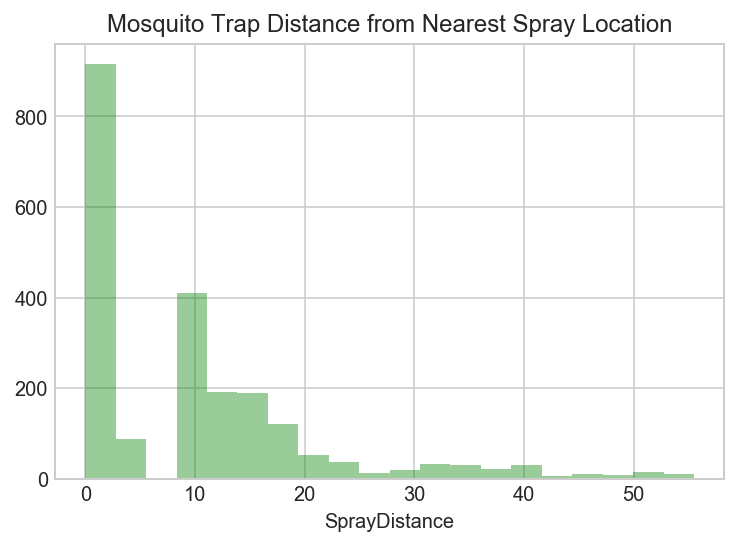

In [174]:
spray = train_spray['SprayDistance'].loc[pd.notnull(train_spray['SprayDistance'])]
sns.distplot(spray, bins=20, kde=False, color="green").set_title("Mosquito Trap Distance from Nearest Spray Location");

### Verify generated training and test dataset with bagging model

In [88]:
train_model = pd.read_csv('../output/train_weather_daily.csv')
train_model.head()
train_model.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal'],
      dtype='object')

In [90]:
test_model = pd.read_csv('../output/test_weather_daily.csv')
test_model.head()
test_model.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Year', 'Month', 'Day', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal'],
      dtype='object')

In [189]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(train_model['Species'].values) + list(test_model['Species'].values))
train_model['Species'] = lbl.transform(train_model['Species'].values)
test_model['Species'] = lbl.transform(test_model['Species'].values)

lbl.fit(list(train_model['Trap'].values) + list(test_model['Trap'].values))
train_model['Trap'] = lbl.transform(train_model['Trap'].values)
test_model['Trap'] = lbl.transform(test_model['Trap'].values)

In [216]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

X = train_model[['Year', 'Trap', 'Heat', 'DewPoint']]
y = train_model['WnvPresent']
ss = preprocessing.StandardScaler()
ss.fit_transform(X)

#  Test set
Xtest = test_model[['Year', 'Trap', 'Heat', 'DewPoint']]
ss.transform(Xtest)

# test/train off train dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [217]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

dt = BaggingClassifier()
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# kaggle test
print(dt.predict(Xtest))
print(dt.predict_proba(Xtest))

s = cross_val_score(dt, X, y, cv=cv)
print("{} Score:\t{:0.3} ± {:0.3}".format("Bagging", s.mean().round(3), s.std().round(3)))

predictions = dt.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predictions)
print('accuracy score:', accuracy)

df_confuse = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confuse

0.939855348306
[0 0 0 ..., 0 0 0]
[[ 1.    0.  ]
 [ 1.    0.  ]
 [ 1.    0.  ]
 ..., 
 [ 0.96  0.04]
 [ 0.96  0.04]
 [ 0.96  0.04]]
Bagging Score:	0.931 ± 0.003
accuracy score: 0.939855348306


Predicted,0,1,All
Actual,,,
0,2450,43,2493
1,115,19,134
All,2565,62,2627


In [218]:
# Creating Kaggle submission file
submission = pd.DataFrame(dt.predict_proba(Xtest), columns=['Id','WnvPresent']).reset_index()
submission= submission[['WnvPresent']]
submission.index += 1
submission.to_csv('../output/bagging_submission5.csv', index_label='Id')